## **Loading Modules and Data**

In [31]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt


In [6]:
#constants
IMAGE_SIZE=256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 50
FILE_PATH="PlantVillage"

In [7]:
#copying only the necessary datasets . doing only potato 
!mkdir "PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Potato___Early_blight/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Potato___healthy" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Potato___Late_blight/" "/kaggle/working/PlantVillage"

mkdir: cannot create directory ‘PlantVillage’: File exists


In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    FILE_PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=(BATCH_SIZE)
)

Found 2152 files belonging to 3 classes.


2022-07-18 19:24:28.781673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 19:24:28.782626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 19:24:28.783354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 19:24:28.784136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 19:24:28.784849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset)

68

## **Data visualization**

In [11]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

2022-07-18 19:24:29.252360: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(32, 256, 256, 3)
[1 1 1 1 0 1 0 0 1 0 1 2 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 2 2]


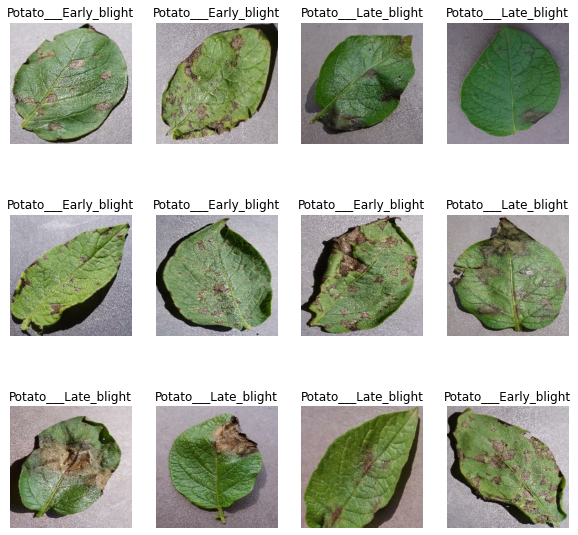

In [12]:

plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

        plt.axis("off")
        




## **Input Split**

In [13]:
train_size = .8
print(len(dataset)*train_size)
valid_size=.1
print(len(dataset)*valid_size)

54.400000000000006
6.800000000000001


In [14]:
train_ds = dataset.take(54)
test_ds = dataset.skip(54)
valid_ds = test_ds.take(6)
test_ds = test_ds.skip(6)

In [15]:
# a cleaner way of data splitting

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    valid_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)
    
    return train_ds, valid_ds, test_ds

In [16]:
train_ds,valid_ds,test_ds = get_dataset_partitions_tf(dataset)

In [17]:
print(len(train_ds))
print(len(valid_ds))
print(len(test_ds))

54
6
8


In [18]:
# improving performance by using CPU and GPU
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## **Image Preprocessing**

In [19]:

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE), # will resize to the IMAGE_SIZE if there's any issue
    layers.experimental.preprocessing.Rescaling(1.0/255), # Normalization
    
])


In [20]:
# data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

## **Building a Model**

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3


model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
#training
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=valid_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50


2022-07-18 19:24:35.046752: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


54/54 [==============================] - 14s 77ms/step - loss: 0.8987 - accuracy: 0.5231 - val_loss: 0.7652 - val_accuracy: 0.7135
Epoch 2/50
54/54 [==============================] - 2s 36ms/step - loss: 0.6758 - accuracy: 0.6985 - val_loss: 0.5574 - val_accuracy: 0.7760
Epoch 3/50
54/54 [==============================] - 2s 36ms/step - loss: 0.3884 - accuracy: 0.8397 - val_loss: 0.2906 - val_accuracy: 0.8802
Epoch 4/50
54/54 [==============================] - 2s 37ms/step - loss: 0.2833 - accuracy: 0.8848 - val_loss: 0.2873 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 2s 36ms/step - loss: 0.2564 - accuracy: 0.8935 - val_loss: 0.3927 - val_accuracy: 0.8490
Epoch 6/50
54/54 [==============================] - 2s 36ms/step - loss: 0.2179 - accuracy: 0.9138 - val_loss: 0.2450 - val_accuracy: 0.8906
Epoch 7/50
54/54 [==============================] - 2s 36ms/step - loss: 0.2509 - accuracy: 0.9005 - val_loss: 0.2748 - val_accuracy: 0.9062
Epoch 8/50
54/54 [=====

In [27]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 0s 14ms/step - loss: 0.0982 - accuracy: 0.9688


[0.09823043644428253, 0.96875]

## **Plotting Model Accuracy**

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

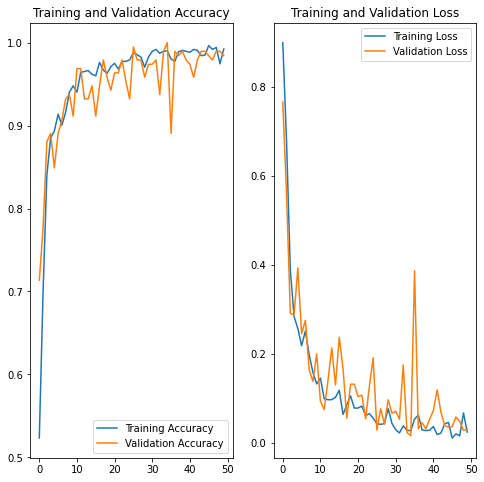

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Running prediction on a sample image**

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Early_blight


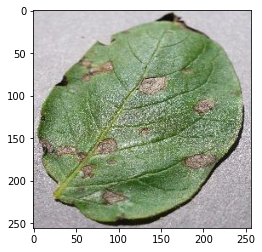

In [35]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
   
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    break
    

## **Predictions**

In [46]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
  

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

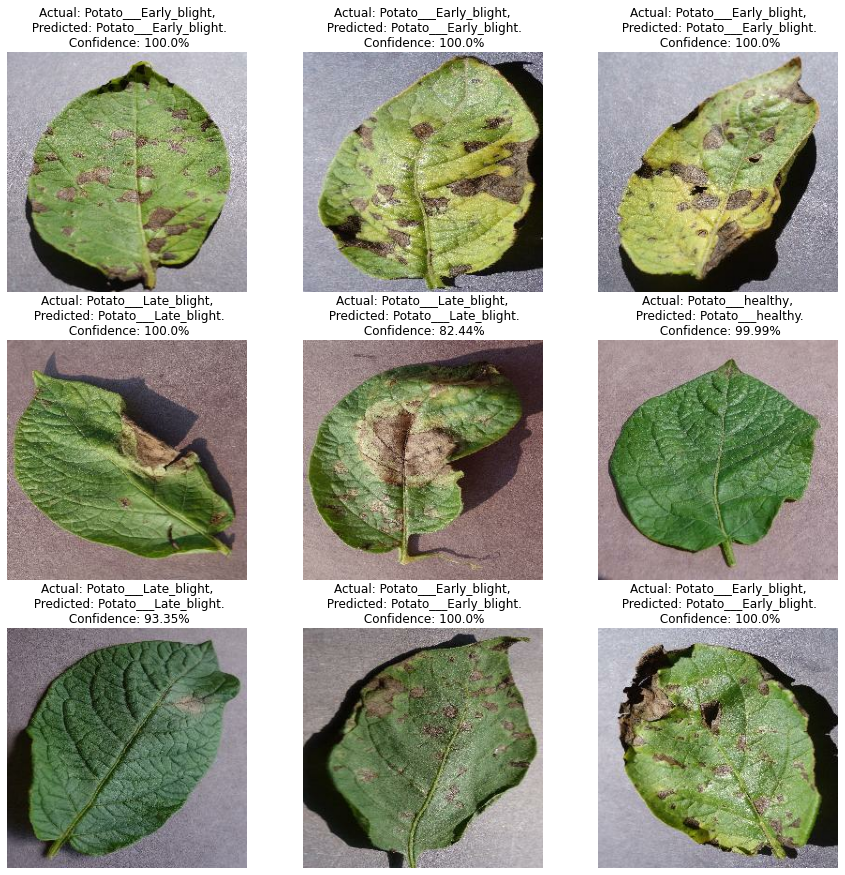

In [47]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## **Saving the model**

In [49]:
!mkdir models

In [51]:

import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")



In [52]:
model.save("potatoes.h5")

In [55]:
os.chdir(r'/kaggle/working')

from IPython.display import FileLink
FileLink(r'potatoes.h5')

/kaggle/working/potatoes.h5